* 이 커널은 [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) 커널을 필사하며 정리한 것입니다.

# Titanic Top 4% with ensemble modeling

* **1 Introduction**

* **2 Load and check data**<br>
 * 2.1 load data
 * 2.2 Outlier detection
 * 2.3 joining train and test set
 * 2.4 check for null and missing values

* **3 Feature analysis**
 * 3.1 Numerical values
 * 3.2 Categorical values

* **4 Filling missing Values**
 * 4.1 Age

* **5 Feature engineering**
 * 5.1 Name/Title
 * 5.2 Family Size
 * 5.3 Cabin
 * 5.4 Ticket

* **6 Modeling**
 * 6.1 Simple modeling
   * 6.1.1 Cross validate models
   * 6.1.2 Hyperparamater tunning for best models
   * 6.1.3 Plot learning curves
   * 6.1.4 Feature importance of the tree based classifiers
 * 6.2 Ensemble modeling
   * 6.2.1 Combining models
 * 6.3 Prediction
   * 6.3.1 Predict and Submit results

<br><br>

## 1. Introduction
이 커널은 크게 세 가지 파트로 나뉩니다.

* **Feature analysis**
* **Feature engineering**
* **Modeling**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

## 2. Load and check data
### 2.1 Load data

In [0]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [0]:
# 이상치 찾기

def detect_outliers(df,n,features):
    # dataframe을 input받아 Tukey method에 따라 n개보다 많은 이상치를 포함하는 
    # 관측치에 해당하는 인덱스 리스트를 반환합니다.
    
    outlier_indices = []
    
    # 각 feature별로 반복
    for col in features:
        # 1사분위수 (25%)
        Q1 = np.percentile(df[col], 25)
        # 3사분위수 (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # feature 열에 대한 이상치의 인덱스 목록 얻기
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # 이상치 인덱스 리스트에 발견한 이상치 인덱스를 추가
        outlier_indices.extend(outlier_list_col)
        
    # n개보다 많은 이상치를 포함하는 관측값 선택
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# Age, SibSp , Parch, Fare에서 이상치를 확인
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

이상치는 (특히 회귀 문제에서) 예측할 때 큰 영향을 주므로 이를 관리하겠습니다.

사분범위(IQR : 1사분위와 3사분위 사이)로 정의되는 이상치를 찾기 위해 Tukey method를 사용했습니다. 이상치는 IQR ± outlier step 바깥에 있는 행입니다.

수치형 변수(Age, SibSp, Parch, Fare)에서 이상치를 찾기로 했습니다. 그 다음 이상치를 적어도 2개 이상의 외부 수치가 있는 행으로 간주했습니다.

In [5]:
train.loc[Outliers_to_drop] # 이상치 행을 확인

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 찾았습니다. 28, 89, 342행은 Fare가 너무 높고 나머지 7개 행은 SibSP가 너무 높습니다.

In [0]:
# 이상치 drop
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 Joining train and test set


In [0]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

범주형 변수를 다룰 때 각 feature가 같은 번호를 갖게 하도록 train과 test를 합칩니다.

<br>

### 2.4 Check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age와 Cabin에서 결측치가 많이 보입니다. Survived의 결측치는 합쳐진 test의 것입니다.

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis
### 3.1 Numerical values

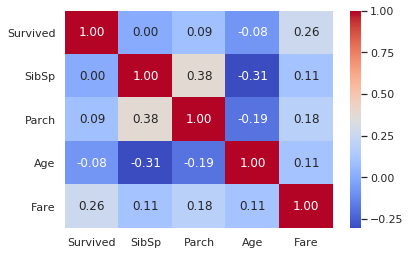

In [13]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),annot=True, fmt='.2f', cmap='coolwarm')

Fare만이 Survival과 눈에 띄는 상관관계를 가진 것으로 보입니다.

나머지 feature들이 필요없다는 것이 아닙니다. 이러한 feature들의 소집단은 Survival과 관계있을 수 있습니다. 이 feature들을 더 자세히 알아보겠습니다.

<br>

#### SibSp

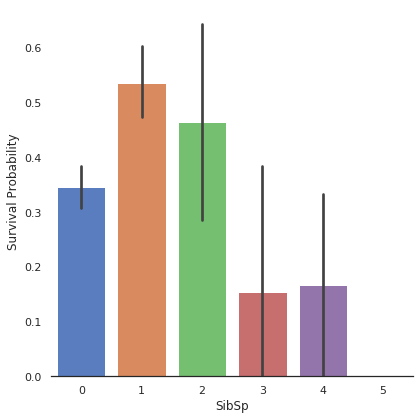

In [14]:
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

형제자매 혹은 배우자가 많은 승객은 생존율이 낮아 보입니다.

혼자거나 SibSp가 1~2인 승객은 나머지 경우보다 생존율이 높아 오빈디ㅏ.

이 관찰결과는 흥미롭습니다. 이러한 범주를 설명하는 새로운 feature를 고려할 수 있습니다.

<br>

#### Parch

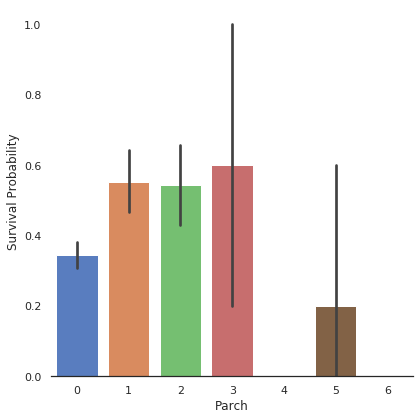

In [15]:
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

소규모 가족은 혼자거나(Parch 0) 중규모(Parch 3,4), 그리고 대규모(Parch 5,6) 가족보다 생존율이 더 높습니다.

부모+자녀가 3명인 승객의 생존여부에 큰 표준편차가 있음을 주의하십시오.

<br>

#### Age

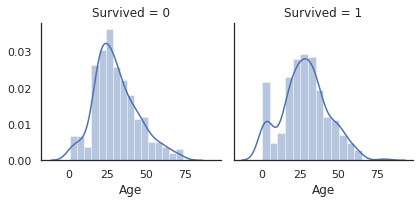

In [16]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Age의 분포는 꼬리 분포 혹은 가우시안 분포로 보입니다.

Age 분포가 생존과 사망에 따라 다르다는 것을 알 수 있습니다. 실제로, 젊은 생존한 승객에 해당하는 peak가 있습니다. 또한 60~80세 사이의 승객은 덜 생존했다는 것을 알 수 있습니다.

따라서 Age가 Survived와 상관관계가 없더라도, 생존율이 높거나 낮은 연령대가 있음을 알 수 있습니다.

매우 어린 승객은 생존율이 더 높습니다.

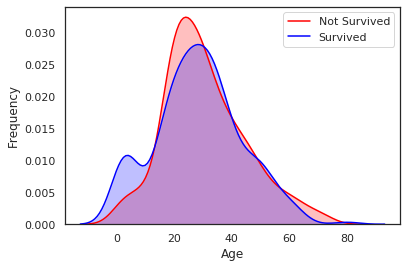

In [17]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

두 밀도를 겹쳐보면, 0~5세 사이의 영유아에 대한 peak를 명확히 볼 수 있습니다.

<br>

#### Fare

In [18]:
dataset['Fare'].isnull().sum()

1

In [0]:
dataset['Fare'] = dataset["Fare"].fillna(dataset['Fare'].median())

결측치가 1개이므로 중앙값으로 대체했습니다.

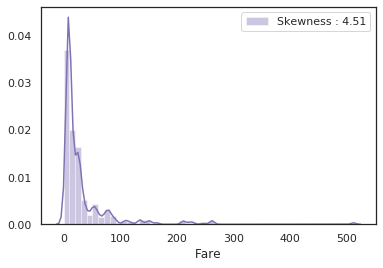

In [20]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

여기서 보듯이, Fare 분포는 매우 치우쳐져 있습니다. 이는 스케일링되더라도 모델에 매우 높은 값의 가중치를 부여할 수 있습니다.

이 경우, log를 씌워 이 치우침을 줄이는 게 좋습니다.

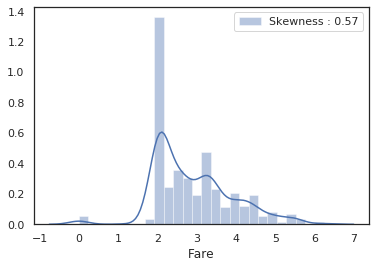

In [21]:
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x>0 else 0)

g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

log를 씌우니 치우침이 확실히 줄어들었습니다.

### 3.2 Categorical values

#### Sex

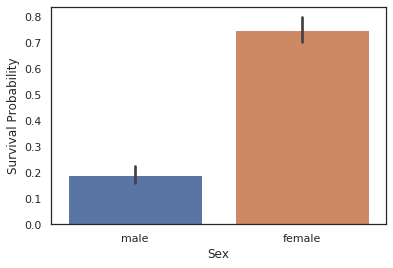

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


명백히 남성의 생존율이 여성보다 낮습니다.

따라서 Sex는 생존 예측에서 중요한 역할을 할 것입니다.

타이타닉 영화를 본 사람이라면 대피하는 동안 "여성과 아이들이 먼저"라는 말을 기억할 것입니다.

<br>

#### Pclass

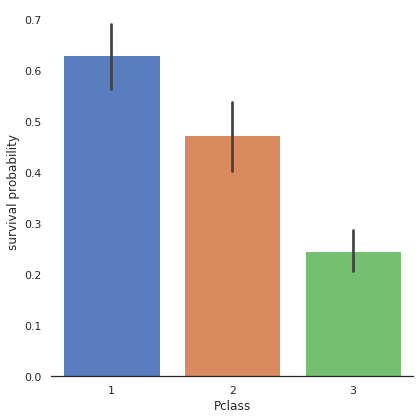

In [24]:
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

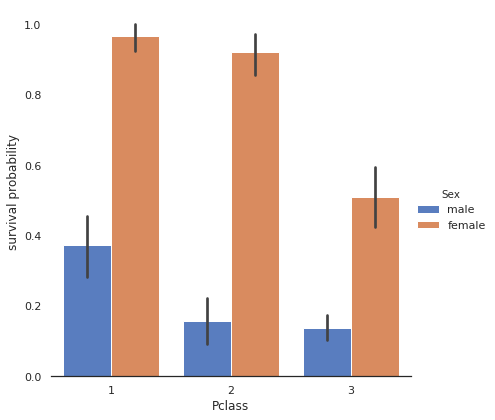

In [25]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

승객의 생존은 3가지 class에서 동일하지 않습니다. 일등석 승객은 이등석 및 삼등석 승객보다 생존율이 높습니다.

이 경향은 성별에 관계없이 보입니다.

<br>

#### Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [0]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

결측값이 두개밖에 없으므로 최빈값으로 대체합니다.

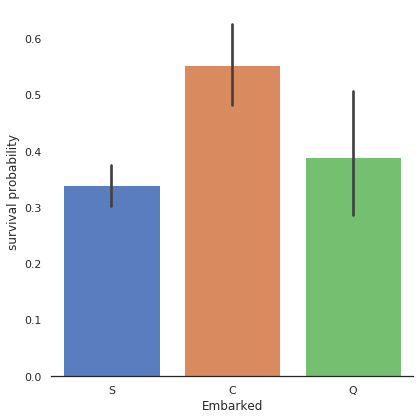

In [28]:
g = sns.factorplot(x="Embarked", y="Survived",  data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

C에서 탑승한 승객이 가장 생존율이 높은 것으로 보입니다.

C에서 탑승한 승객 중 일등석 승객의 비율이 높아서 그런 것으로 보입니다. Pclass vs Embarked 분포를 보겠습니다.

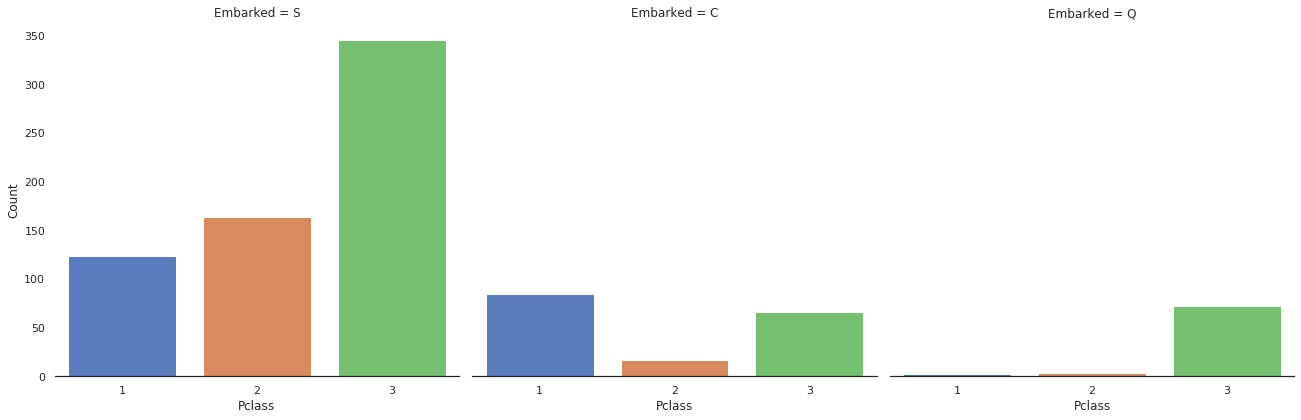

In [29]:
g = sns.factorplot("Pclass", col="Embarked",  data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

실제로 삼등석 승객은 S와 Q에서 가장 많이 타는 반면 C의 승객은 대부분 생존율이 가장 높은 일등석 승객입니다.


## 4. Filling missing Values
### 4.1 Age

앞에서 살펴봤듯이 Age column은 전체 데이터셋에서 256개의 결측값을 가지고 있습니다.

생존율이 높은 소집단이 있으므로(어린이 등) Age feature를 유지하고 결측값을 impute하는 게 좋습니다.

이 문제를 해결하기 위해 Age와 가장 상관관계가 높은 feature들(Sex, Parch, Pclass, SibSp)을 살펴봤습니다.

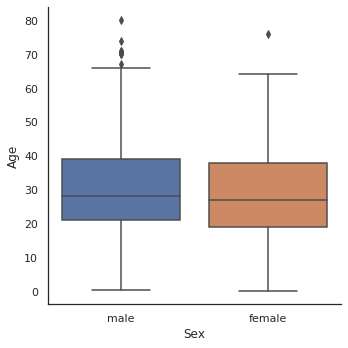

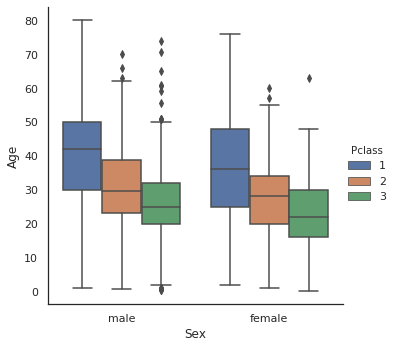

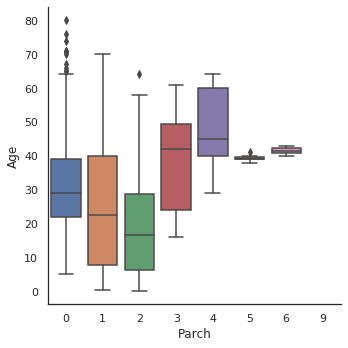

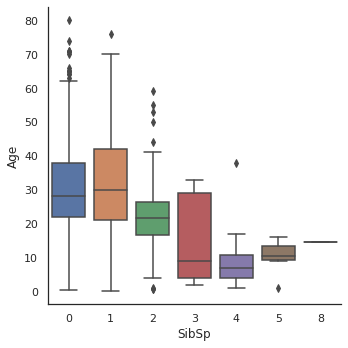

In [30]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

Age의 분포는 성별간에 차이가 없어 보입니다. 따라서 Sex는 Age를 예측하기에 유용하지 않습니다.

하지만 class가 높을수록 나이가 많습니다. 또한 승객의 나이가 많을수록 부모/자녀가 많고, 나이가 어릴수록 형제/배우자가 많습니다.

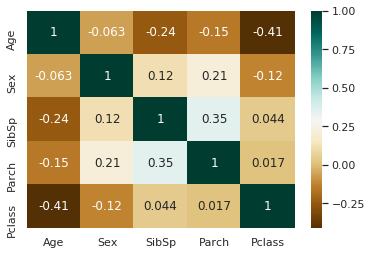

In [31]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

이 히트맵은 Parch를 제외한 factorplot 관찰결과를 확인합니다. Age는 Sex와 관계가 없지만 Pclass, Parch, SibSp와 음의 상관관계가 있습니다.

Parch와 Age의 plot에서는 부모/자녀 수가 증가할수록 Age도 증가했습니다. 하지만 일반적인 상관관계는 음으로 나옵니다.

결측값을 채우기 위해 SibSp, Parch, Pclass를 사용합니다. 각 feature와 유사한 행의 중간 나이로 Age 값을 채웁니다.

In [0]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

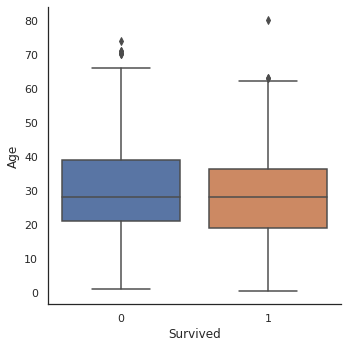

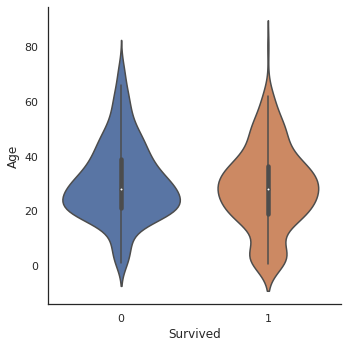

In [33]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

생존과 사망에 있어 Age의 중간값에 차이가 없습니다.

하지만 생존의 violin plot은 매우 어린 승객의 생존율이 높다는 것을 보여줍니다.

<br><br>

## 5. Feature engineering
### 5.1 Name/Title

In [34]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name feature는 승객의 타이틀에 대한 정보를 갖고 있습니다.

어떤 타이틀의 승객은 대피 중 다른 승객보다 우선시될 수 있으므로, 모델에 추가하는 것이 흥미롭습니다.

In [35]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

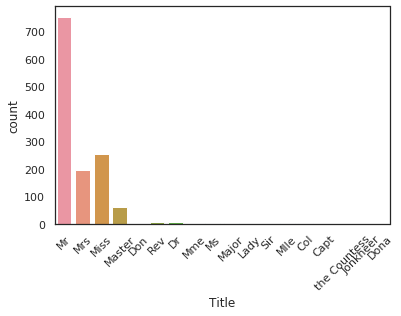

In [36]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

17개의 title이 있습니다. 대부분은 매우 희귀한 타이틀이므로 4개로 분류하겠습니다.

In [0]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

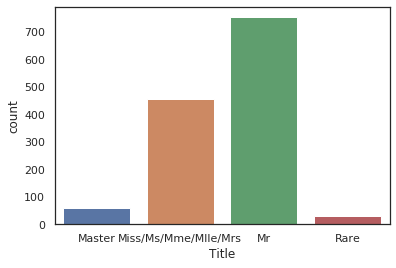

In [38]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

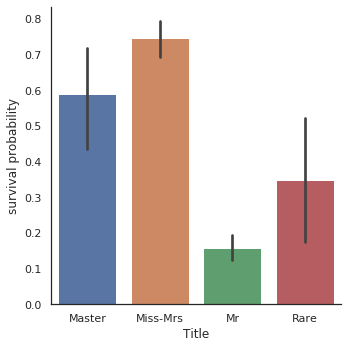

In [39]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

"여자와 아이 우선"

희귀한 타이틀을 가진 승객의 생존율이 비교적 높은 것이 흥미롭습니다.

In [0]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family Size
규모가 큰 가족은 그들의 형제/부모를 찾느라 탈출에 더욱 어려움이 있을 것이라 짐작할 수 있습니다. 그러므로 Parch + SibSp + 1(본인)으로 "Fsize"(Family size) feature를 만들었습니다.

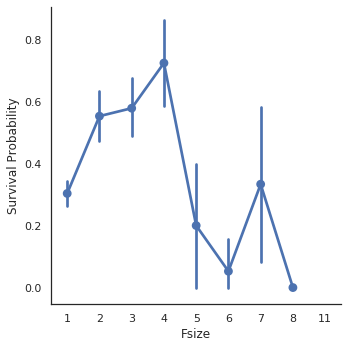

In [41]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

family size는 큰 규모의 가족의 나쁜 생존율에 중요한 역할을 하는 것으로 보입니다.

여기에 family size에 대한 4개의 카테고리를 만들었습니다.

In [0]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

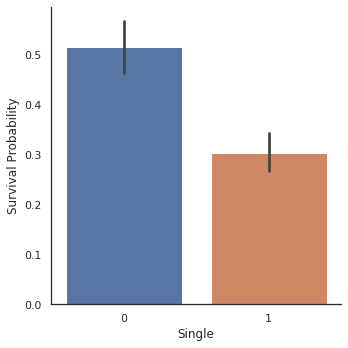

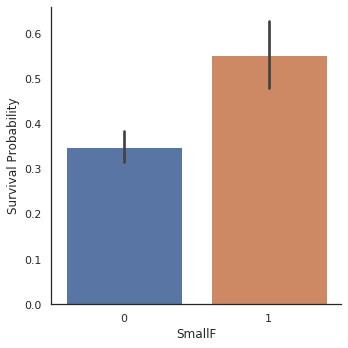

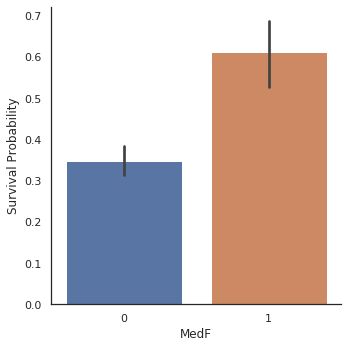

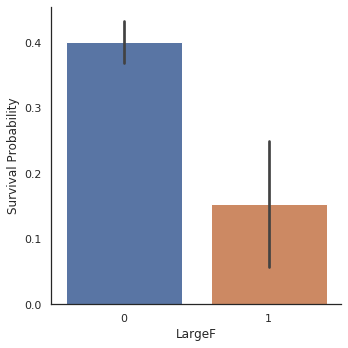

In [43]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

family size의 factorplot은 Small, Medium 승객보다 Single, Large 승객의 생존율이 더 높음을 보여주고 있습니다.

In [44]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,2,0,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,2,0,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1,1,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,2,0,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0,0,0,0,1,0,0,0,1


이 시점에서 feature는 22개입니다.